In [1]:
from pydantic_settings import BaseSettings
from dotenv import load_dotenv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import os
import time
import uuid
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sqlalchemy.sql import text
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from typing import List, TypedDict, Dict, Any, Optional
from typing_extensions import TypedDict
from pydantic import BaseModel, Field
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import HumanMessage,  SystemMessage
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import sessionmaker
from sqlalchemy import create_engine, Column, Integer, Float, String, MetaData, Table
from langgraph.checkpoint.postgres import PostgresSaver
load_dotenv()

True

In [2]:
llm = ChatOpenAI(model="gpt-4o-mini") 

### Code for uploading the csv file to a database and also connecting to postgres database using sqlalchemy

In [3]:
class Settings(BaseSettings):
    database_hostname: str
    database_port: str
    database_password: str
    database_name: str
    database_username: str

    openai_api_key: str
    langsmith_tracing: bool
    langsmith_endpoint: str
    langsmith_api_key: str
    langsmith_project: str
    tavily_api_key: str
    upload_folder: str
    class Config:
        env_file = ".env"
        extra = "allow"


settings = Settings()

In [4]:
def infer_column_types(df):
    """Infer SQL column types from DataFrame"""
    type_map = {}
    
    for col in df.columns:
        if pd.api.types.is_integer_dtype(df[col]):
            type_map[col] = Integer
        elif pd.api.types.is_float_dtype(df[col]):
            type_map[col] = Float
        else:
            type_map[col] = String(255)
    
    return type_map

In [5]:
infer_column_types("train.csv")

AttributeError: 'str' object has no attribute 'columns'

In [5]:
def create_database_and_table(df, database_name=None, table_name=None):
    """Create a new database and table based on DataFrame schema"""
    
    if database_name is None:
        database_name = settings.database_name
        if database_name is None:  
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            database_name = f"analysis_db_{timestamp}"
    
    if table_name is None:
        table_name = "data_table"
    
    settings.database_name = database_name

    admin_engine = create_engine(
        f"postgresql+psycopg2://{settings.database_username}:{settings.database_password}@"
        f"{settings.database_hostname}:{settings.database_port}/postgres"
    )
    
    with admin_engine.connect() as conn:
        conn.execution_options(isolation_level="AUTOCOMMIT")
        conn.execute(text(f"SELECT pg_terminate_backend(pid) FROM pg_stat_activity WHERE datname = '{database_name}'"))
        conn.execute(text(f"DROP DATABASE IF EXISTS {database_name}"))
        conn.execute(text(f"CREATE DATABASE {database_name}"))

    db_engine = create_engine(
        f"postgresql+psycopg2://{settings.database_username}:{settings.database_password}@"
        f"{settings.database_hostname}:{settings.database_port}/{database_name}"
    )
    
    metadata = MetaData()
    columns = [Column('id', Integer, primary_key=True)]
    schema_info = {'id': 'Integer (primary key)'}

    # Infer column types
    column_types = infer_column_types(df)
    for col_name, sql_type in column_types.items():
        safe_col_name = col_name.replace(' ', '_').lower()
        columns.append(Column(safe_col_name, sql_type))
        schema_info[safe_col_name] = sql_type.__name__ if isinstance(sql_type, type) else str(sql_type)

    table = Table(table_name, metadata, *columns)
    metadata.create_all(db_engine)

    df_to_insert = df.copy()
    df_to_insert.columns = [col.replace(' ', '_').lower() for col in df.columns]

    with db_engine.connect() as conn:
        batch_size = 1000
        for i in range(0, len(df_to_insert), batch_size):
            batch = df_to_insert.iloc[i:i+batch_size]
            batch.to_sql(table_name, conn, if_exists='append', index=False)

    return {
        'database_name': database_name,
        'table_name': table_name,
        'schema': schema_info,
        'engine': db_engine
    }

In [7]:
def create_databases_and_tables(df, data_db_name=None, memory_db_name=None, table_name=None):
    """Create two databases: one for storing CSV data and another for memory"""

    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    if data_db_name is None:
        data_db_name = f"analysis_db_{timestamp}"
    if memory_db_name is None:
        memory_db_name = "memory_db"

    if table_name is None:
        table_name = "data_table"

    settings.database_name = data_db_name

    admin_engine = create_engine(
        f"postgresql+psycopg2://{settings.database_username}:{settings.database_password}@"
        f"{settings.database_hostname}:{settings.database_port}/postgres"
    )

    with admin_engine.connect() as conn:
        conn.execution_options(isolation_level="AUTOCOMMIT")
        
        conn.execute(text(f"SELECT pg_terminate_backend(pid) FROM pg_stat_activity WHERE datname = '{data_db_name}'"))
        conn.execute(text(f"DROP DATABASE IF EXISTS {data_db_name}"))
        conn.execute(text(f"CREATE DATABASE {data_db_name}"))

        conn.execute(text(f"SELECT pg_terminate_backend(pid) FROM pg_stat_activity WHERE datname = '{memory_db_name}'"))
        conn.execute(text(f"DROP DATABASE IF EXISTS {memory_db_name}"))
        conn.execute(text(f"CREATE DATABASE {memory_db_name}"))

    # Connect to data database
    data_engine = create_engine(
        f"postgresql+psycopg2://{settings.database_username}:{settings.database_password}@"
        f"{settings.database_hostname}:{settings.database_port}/{data_db_name}"
    )

    # Connect to memory database
    memory_engine = create_engine(
        f"postgresql+psycopg2://{settings.database_username}:{settings.database_password}@"
        f"{settings.database_hostname}:{settings.database_port}/{memory_db_name}"
    )

    # Create table for CSV data
    metadata = MetaData()
    columns = [Column('id', Integer, primary_key=True)]
    schema_info = {'id': 'Integer (primary key)'}

    column_types = infer_column_types(df)
    for col_name, sql_type in column_types.items():
        safe_col_name = col_name.replace(' ', '_').lower()
        columns.append(Column(safe_col_name, sql_type))
        schema_info[safe_col_name] = sql_type.__name__ if isinstance(sql_type, type) else str(sql_type)

    table = Table(table_name, metadata, *columns)
    metadata.create_all(data_engine)

    df_to_insert = df.copy()
    df_to_insert.columns = [col.replace(' ', '_').lower() for col in df.columns]

    with data_engine.connect() as conn:
        batch_size = 1000
        for i in range(0, len(df_to_insert), batch_size):
            batch = df_to_insert.iloc[i:i+batch_size]
            batch.to_sql(table_name, conn, if_exists='append', index=False)

    # Create table for memory storage
    memory_metadata = MetaData()
    memory_table = Table(
        "memory_store", memory_metadata,
        Column("id", Integer, primary_key=True),
        Column("session_id", String, nullable=False),
        Column("state", String, nullable=False)
    )
    memory_metadata.create_all(memory_engine)

    
    memory_saver = PostgresSaver(f"postgresql://{settings.database_username}:{settings.database_password}@"
                                 f"{settings.database_hostname}:{settings.database_port}/{memory_db_name}")

    return {
        "data_database_name": data_db_name,
        "memory_database_name": memory_db_name,
        "table_name": table_name,
        "data_engine": data_engine,
        "memory_engine": memory_engine,
        "schema": schema_info,
        "memory_saver": memory_saver
    }


In [6]:
def get_db_connection(database_name=None):
    """Get a database connection to the specified database"""
    db_name = database_name or settings.database_name
    
    if not db_name:
        raise ValueError("No database name specified")
    
    engine = create_engine(
        f"postgresql+psycopg2://{settings.database_username}:{settings.database_password}@"
        f"{settings.database_hostname}:{settings.database_port}/{db_name}"
    )
    
    SessionLocal = sessionmaker(autoflush=False, bind=engine, autocommit=False)
    db = SessionLocal()
    
    return db, engine

### Generate data analyst with human in the loop

In [11]:
class Analyst(BaseModel):
    name: str = Field(description="Name of the analyst.")
    affiliation: str = Field(description="Primary affiliation of the analyst.")
    role: str = Field(description="Role of the analyst in the context of data analysis.")
    data_analysis_focus: str = Field(description="Primary focus area in data analysis (e.g., Machine Learning, Statistical Analysis, Data Engineering).")
    description: str = Field(description="Description of the analyst's expertise, concerns, and analysis approach.")
    analysis_results: Optional[Dict[str, Any]] = Field(default_factory=dict, description="Results of the analyst's work.")
    database_interactions: Optional[List[Dict[str, Any]]] = Field(default_factory=list, description="Database queries and transformations performed by the analyst.")

    @property
    def persona(self) -> str:
        return (
            f"Name: {self.name}\n"
            f"Role: {self.role}\n"
            f"Affiliation: {self.affiliation}\n"
            f"Focus: {self.data_analysis_focus}\n"
            f"Description: {self.description}\n"
        )


class Perspectives(BaseModel):
    analysts: List[Analyst] = Field(description="List of analysts contributing to the data analysis.")
    analysis_summary: str = Field(description="Findings of each analysts.")

    class Config:
        schema_extra = {
            "required": ["analysts", "analysis_summary"]
        }
        
        
class GenerateAnalystsState(TypedDict):
    csv_path: str 
    analysis_goal: str  
    max_analysts: int
    human_analyst_feedback: Optional[str]
    database_name: Optional[str] 
    table_name: Optional[str]  
    analysts: Optional[List[Analyst]]
    data_df: Dict[str, Any] 
    ml_models: Dict[str, Any]
    visualizations: Dict[str, str] 
    database_schema: Optional[Dict[str, str]] 
    analysis_summary: Optional[str]

In [12]:
analyst_instructions = """
  You are responsible for creating a team of AI analyst personas that will collaborate to achieve specific data analysis goals. 
Each analyst should specialize in a distinct role and contribute effectively to the overall analysis process. Follow these instructions carefully:

---

Step 1: Understand the Analysis Goal  
- Review the primary analysis goal that the AI analysts need to accomplish:  
  Goal: {analyst_goal}  
- Determine the scope of the analysis, including key challenges and expected outcomes.  
- Pick the top {max_analysts} analyst.  

Step 2: Incorporate Human Feedback (If Provided)  
- If any editorial feedback or domain-specific instructions are provided, integrate them into the analysis plan:  
  Feedback: {human_analyst_feedback}  
- Adjust the analysts' approaches accordingly to align with expert guidance.  

Step 3: Identify Core Analytical Themes  
- Break down the analysis goal into key sub-goals that require specialized expertise.  
- Determine the most relevant aspects of the dataset that must be examined.  
- Consider important data-related tasks such as:  
  - Data cleaning and preprocessing  
  - Exploratory Data Analysis (EDA)  
  - Statistical insights and hypothesis testing  
  - Predictive modeling or machine learning  
  - Data visualization and reporting  

Step 4: Define a Team of Specialized AI Analysts  
Assign one AI analyst persona to each identified sub-goal.  
Each analyst should have distinct expertise while contributing to the overall objective.  
Ensure diversity in roles by selecting from the following:  

1. Database Engineer  
   - Responsible for database creation, management, and query optimization.  
   - Ensures efficient data retrieval, indexing, and schema design.  
   - Works with SQL/PostgreSQL, NoSQL, and data warehouses.  

2. Data Engineer  
   - Focuses on data extraction, transformation, and loading (ETL).  
   - Cleans and preprocesses raw data for analysis.  
   - Handles large-scale data pipelines and ensures data integrity.  

3. Statistical Analyst  
   - Performs rigorous statistical testing and hypothesis validation.  
   - Uses techniques like regression analysis, ANOVA, and probability modeling.  
   - Ensures statistical soundness in insights and interpretations.  

4. Machine Learning Specialist  
   - Develops predictive models and applies machine learning techniques.  
   - Tunes hyperparameters and validates model performance.  
   - Works with libraries such as Scikit-learn, TensorFlow, or PyTorch.  

5. Data Visualization Expert  
   - Translates complex data into intuitive and interactive visualizations.  
   - Uses tools like Matplotlib, Seaborn, Power BI, and Tableau.  
   - Ensures insights are clear and accessible to non-technical stakeholders.  

6. Domain Expert (Optional)  
   - Provides industry-specific knowledge to contextualize findings.  
   - Ensures the analysis aligns with real-world applications in healthcare, finance, etc.  

Step 5: Define Each Analyst’s Approach  
For each assigned AI analyst persona, provide a detailed description of:  
  - Their area of expertise  
  - Their approach to solving the assigned sub-goal  
  - The methods and tools they will use  
  - The expected outputs from their analysis  

Step 6: Execute the Analysis as a Collaborative Multi-Agent System  
- Ensure that each AI analyst persona works cohesively towards the final analysis goal.  
- The outputs from one analyst may serve as inputs for another (e.g., the Data Engineer preps data for the Machine Learning Specialist).  
- Optimize the workflow for efficiency, accuracy, and interpretability.  

---

Outcome: A structured and effective multi-agent AI analysis team, with each persona assigned a well-defined role, working together to accomplish the specified goal.  

"""

In [13]:
def process_csv_and_create_db(state: GenerateAnalystsState):
    """Load CSV and create database"""
    csv_path = state['csv_path']
    
    try:
        df = pd.read_csv(csv_path)
        
        db_info = create_database_and_table(
            df, 
            database_name=state.get('database_name'),
            table_name=state.get('table_name')
        )
        
        state["data_df"] = {"raw": df.to_dict(orient="records")}
        
        return {
            'data_df': state["data_df"],
            "database_name": db_info['database_name'],
            "table_name": db_info['table_name'],
            "database_schema": db_info['schema']
        }
    except Exception as e:
        return {
            "data_df": {"error": str(e)},
            "error_message": f"Failed to process CSV and create database: {str(e)}"
        }

In [14]:
import json
def create_analysts(state: GenerateAnalystsState):
    """Create analysts based on the dataset and analysis goals"""
    try:
        if isinstance(state["data_df"], str):  
            state["data_df"] = json.loads(state["data_df"]) 

        if not isinstance(state["data_df"], dict):
            raise ValueError("data_df is not a valid dictionary")

    except Exception as e:
        print(f"⚠️ Error parsing data_df: {e}")
        state["data_df"] = {}

  
    db_info = f"Database: {state['database_name']}, Table: {state['table_name']}"
    schema_info = "Schema: " + ", ".join([f"{k}: {v}" for k, v in state.get("database_schema", {}).items()])
    
    data_sample = "Sample data: (No valid data found)"
    if "raw" in state["data_df"]:
        try:
            data_sample = "Sample data: " + str(state["data_df"]["raw"].head(3).to_dict())
        except AttributeError:
            print("⚠️ 'raw' key is present but not a DataFrame. Ensure correct format.")

    goal = f"{db_info}\n{schema_info}\n{data_sample}\n\nAnalysis Goal: {state['analysis_goal']}"
    max_analysts = int(state.get("max_analysts", 4))
    human_analyst_feedback = state.get("human_analyst_feedback", "")

  
    structured_llm = llm.with_structured_output(Perspectives)

    
    system_message = analyst_instructions.format(
        analyst_goal=goal,
        human_analyst_feedback=human_analyst_feedback, 
        max_analysts=max_analysts
    )

   
    perspectives = structured_llm.invoke([
        SystemMessage(content=system_message),
        HumanMessage(content="Generate the set of analysts that will create and interact with the database, analyze the data, clean it, visualize it, perform data engineering tasks, and build machine learning models.")
    ])
    
   
    return {"analysts": perspectives.analysts, "analysis_summary": perspectives.analysis_summary}

In [15]:
def perform_database_interactions(state: GenerateAnalystsState):
    """Have analysts interact with the database to perform various queries and transformations"""
    database_name = state['database_name']
    table_name = state['table_name']
    analysts = state['analysts']
    
    db, engine = get_db_connection(database_name)
    
    try:
        all_interactions = []
        
        # Find database-focused analysts
        db_analysts = [a for a in analysts if "Database" in a.data_analysis_focus or "Data Engineer" in a.role]
        
        for analyst in db_analysts:
            interactions = []
            
            stats_query = f"""
            SELECT 
                COUNT(*) as row_count,
                (SELECT COUNT(*) FROM information_schema.columns WHERE table_name = '{table_name}') as column_count
            FROM {table_name}
            """
            stats_result = pd.read_sql(stats_query, engine)
            row_count = stats_result.iloc[0]['row_count']
            column_count = stats_result.iloc[0]['column_count']
            
            interactions.append({
                "query": stats_query,
                "description": "Basic table statistics",
                "result_summary": f"Table has {row_count} rows and {column_count} columns"
            })
            
            column_query = f"""
            SELECT column_name, data_type
            FROM information_schema.columns
            WHERE table_name = '{table_name}'
            AND data_type IN ('integer', 'numeric', 'real', 'double precision')
            """
            numeric_cols = pd.read_sql(column_query, engine)
            
            if not numeric_cols.empty:
                col_names = numeric_cols['column_name'].tolist()
                agg_cols = ", ".join([f"AVG({col}) as avg_{col}, MIN({col}) as min_{col}, MAX({col}) as max_{col}" 
                                     for col in col_names])
                
                agg_query = f"""
                SELECT {agg_cols}
                FROM {table_name}
                """
                
                agg_results = pd.read_sql(agg_query, engine)
                interactions.append({
                    "query": agg_query,
                    "description": "Aggregate statistics on numeric columns",
                    "result_summary": "Calculated AVG, MIN, MAX for all numeric columns"
                })
                
                if col_names: 
                    view_name = f"agg_{table_name}_view"
                    create_view_query = f"""
                    CREATE OR REPLACE VIEW {view_name} AS
                    SELECT {', '.join(col_names)}
                    FROM {table_name}
                    """

                    with engine.connect() as conn:
                        conn.execute(text(create_view_query))
                        conn.commit()

                    interactions.append({
                        "query": create_view_query,
                        "description": "Created aggregated view for ML analysis",
                        "result_summary": f"View {view_name} created with columns: {', '.join(col_names)}"
                    })
            
            analyst.database_interactions = interactions
            all_interactions.extend(interactions)
        
        return {
            "database_interactions": all_interactions
        }
        
    except Exception as e:
        return {
            "database_interactions": [],
            "error_message": f"Failed to perform database interactions: {str(e)}"
        }
    finally:
        db.close()

In [17]:
def data_cleaning_and_enrichment(state: GenerateAnalystsState):
    """Clean and enrich the data, updating the database with cleaned data"""
    if "data_df" not in state or not isinstance(state["data_df"], dict):
        return {
            "error_message": "Invalid data format: 'data_df' should be a dictionary."
        }
    
    # Reconstruct DataFrame from serialized format
    if "raw" in state["data_df"] and isinstance(state["data_df"]["raw"], list):
        raw_df = pd.DataFrame(state["data_df"]["raw"])
    else:
        return {
            "error_message": "Invalid data format: 'raw' key is missing or not a list."
        }
    
    # Clean the data
    clean_df = raw_df.copy()
    
    for col in clean_df.columns:
        if pd.api.types.is_numeric_dtype(clean_df[col]):
            clean_df[col] = clean_df[col].fillna(clean_df[col].mean())
        else:
            clean_df[col] = clean_df[col].fillna(clean_df[col].mode()[0] if not clean_df[col].mode().empty else "Unknown")
    
    clean_df = clean_df.drop_duplicates()
    
    # Enrich the data
    numeric_cols = clean_df.select_dtypes(include=['float64', 'int64']).columns
    
    if len(numeric_cols) >= 2:
        col1, col2 = numeric_cols[0], numeric_cols[1]
        clean_df[f'sum_{col1}_{col2}'] = clean_df[col1] + clean_df[col2]
        
        if (clean_df[col2] != 0).all():
            clean_df[f'ratio_{col1}_{col2}'] = clean_df[col1] / clean_df[col2]
    
    # Save cleaned data to the database
    db, engine = get_db_connection(state['database_name'])
    try:
        cleaned_table_name = f"{state['table_name']}_cleaned"
        clean_df.to_sql(cleaned_table_name, engine, if_exists='replace', index=False)
        
        # Update state with serialized cleaned data
        state["data_df"]["cleaned"] = clean_df.to_dict(orient="records")
        state["cleaned_table_name"] = cleaned_table_name
        
        return {
            "data_df": state["data_df"],
            "cleaned_table_name": cleaned_table_name
        }
    except Exception as e:
        return {
            "data_df": state["data_df"],
            "error_message": f"Failed to save cleaned data to database: {str(e)}"
        }
    finally:
        db.close()

In [18]:
def data_visualization(state):
    """Create visualizations of the data"""
    # Validate input data structure
    if not isinstance(state.get("data_df"), dict) or "cleaned" not in state["data_df"]:
        return {"error_message": "Invalid data format: 'data_df' must be a dictionary with a 'cleaned' key."}
    
    clean_df = state["data_df"]["cleaned"]
    
    # Ensure clean_df is a DataFrame
    if not isinstance(clean_df, pd.DataFrame):
        return {"visualizations": json.dumps(clean_df, default=str)}

    visualizations = {}
    
    # Create directory for visualizations
    viz_dir = os.path.join(settings.upload_folder, 'visualizations')
    os.makedirs(viz_dir, exist_ok=True)
    
    # Prefix for filenames
    viz_prefix = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Select numeric columns
    numeric_cols = clean_df.select_dtypes(include=['float64', 'int64']).columns.tolist()
    
    # Correlation Heatmap
    if len(numeric_cols) > 1:
        plt.figure(figsize=(10, 8))
        corr = clean_df[numeric_cols].corr()
        sns.heatmap(corr, annot=True, cmap='coolwarm')
        plt.title('Correlation Heatmap')
        plt.tight_layout()
        corr_file = os.path.join(viz_dir, f'{viz_prefix}_correlation_heatmap.png')
        plt.savefig(corr_file)
        plt.close()
        visualizations['correlation'] = corr_file
    
    # Distribution Plots
    for col in numeric_cols[:3]:
        plt.figure(figsize=(8, 6))
        sns.histplot(clean_df[col], kde=True)
        plt.title(f'Distribution of {col}')
        dist_file = os.path.join(viz_dir, f'{viz_prefix}_dist_{col}.png')
        plt.savefig(dist_file)
        plt.close()
        visualizations[f'dist_{col}'] = dist_file
    
    # Pair Plot
    if len(numeric_cols) > 1:
        plot_cols = numeric_cols[:min(4, len(numeric_cols))]
        sns_pairplot = sns.pairplot(clean_df[plot_cols])
        pair_file = os.path.join(viz_dir, f'{viz_prefix}_pair_plot.png')
        sns_pairplot.savefig(pair_file)
        plt.close()
        visualizations['pair_plot'] = pair_file
    
    # Box Plots
    if numeric_cols:
        plt.figure(figsize=(12, 6))
        sns.boxplot(data=clean_df[numeric_cols[:min(6, len(numeric_cols))]])
        plt.title('Box Plots of Numeric Features')
        plt.xticks(rotation=45)
        box_file = os.path.join(viz_dir, f'{viz_prefix}_box_plots.png')
        plt.savefig(box_file)
        plt.close()
        visualizations['box_plots'] = box_file
    
    return {"visualizations": json.dumps(visualizations)} 

In [19]:
def build_ml_models(state: GenerateAnalystsState):
    """Build machine learning models based on the cleaned data"""
    # Check if data_df is a dictionary and contains the "cleaned" key
    if not isinstance(state["data_df"], dict) or "cleaned" not in state["data_df"]:
        return {
            "error_message": "Invalid data format: 'data_df' must be a dictionary with a 'cleaned' key."
        }
    
    clean_df = state["data_df"]["cleaned"]
    
    # Ensure clean_df is a DataFrame
    if not isinstance(clean_df, pd.DataFrame):
        return {
            "error_message": "Invalid data format: 'cleaned' key must contain a pandas DataFrame."
        }
    
    ml_models = {}
    
    # Identify numeric features
    numeric_features = clean_df.select_dtypes(include=['float64', 'int64']).columns
    
    if len(numeric_features) > 1:
        X_cols = numeric_features[:-1]
        y_col = numeric_features[-1]
        
        X = clean_df[X_cols]
        y = clean_df[y_col]
        
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Basic linear regression model
        model = LinearRegression()
        model.fit(X_train_scaled, y_train)
        
        # Evaluate model
        train_score = model.score(X_train_scaled, y_train)
        test_score = model.score(X_test_scaled, y_test)
        
        ml_models['linear_regression'] = {
            'model': model,
            'train_score': train_score,
            'test_score': test_score,
            'features': list(X.columns),
            'target': y_col,
            'coefficients': {feature: coef for feature, coef in zip(X.columns, model.coef_)}
        }
        
        # Random Forest model
        rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
        rf_model.fit(X_train_scaled, y_train)
        
        rf_train_score = rf_model.score(X_train_scaled, y_train)
        rf_test_score = rf_model.score(X_test_scaled, y_test)
        
        ml_models['random_forest'] = {
            'model': rf_model,
            'train_score': rf_train_score,
            'test_score': rf_test_score,
            'features': list(X.columns),
            'target': y_col,
            'feature_importance': {feature: importance for feature, importance in 
                                 zip(X.columns, rf_model.feature_importances_)}
        }
        
        # Save model results to the database
        db, engine = get_db_connection(state['database_name'])
        try:
            model_results = pd.DataFrame({
                'model_name': ['linear_regression', 'random_forest'],
                'train_score': [train_score, rf_train_score],
                'test_score': [test_score, rf_test_score],
                'target_variable': [y_col, y_col],
                'timestamp': [datetime.now(), datetime.now()]
            })
            
            model_results.to_sql('model_results', engine, if_exists='replace', index=False)
            
        except Exception as e:
            ml_models['error'] = str(e)
        finally:
            db.close()
    
    return {"ml_models": ml_models}

In [20]:
def generate_analysis_report(state: GenerateAnalystsState):
    """Generate a comprehensive analysis report based on all the previous steps"""
    
   
    print("Starting generate_analysis_report")
    print(f"ml_models type: {type(state.get('ml_models'))}")
    
    analysts = state.get('analysts', [])
    data_df = state.get('data_df', {})
    visualizations = state.get('visualizations', {})
    ml_models = state.get('ml_models', {})
    database_name = state.get('database_name', 'unknown')
    table_name = state.get('table_name', 'unknown')
    cleaned_table_name = state.get('cleaned_table_name', 'None')
    database_interactions = state.get('database_interactions', [])
    
    if not isinstance(ml_models, dict):
        print(f"Converting ml_models from {type(ml_models)} to dict")
        ml_models = {'error': str(ml_models)}
    
    for analyst in analysts:
        if not hasattr(analyst, 'analysis_results') or analyst.analysis_results is None:
            analyst.analysis_results = {}
        
        if hasattr(analyst, 'data_analysis_focus'):
            focus = analyst.data_analysis_focus
        else:
            focus = "Unknown"
            
        print(f"Processing analyst with focus: {focus}")
            
        if isinstance(focus, str) and "Database" in focus:
            analyst.analysis_results['database_summary'] = {
                'database_created': database_name,
                'tables_created': [table_name, cleaned_table_name],
                'interactions_count': len(database_interactions)
            }
        
        elif isinstance(focus, str) and "Data Engineering" in focus:
            if isinstance(data_df, dict) and 'cleaned' in data_df and 'raw' in data_df:
                rows_before = len(data_df['raw'])
                rows_after = len(data_df['cleaned'])
                analyst.analysis_results['data_cleaning'] = {
                    'rows_before': rows_before,
                    'rows_after': rows_after,
                    'cleaning_efficiency': f"{(rows_after/rows_before*100):.1f}%",
                    'cleaned_table': cleaned_table_name
                }
        
        elif isinstance(focus, str) and "Visualization" in focus:
            if isinstance(visualizations, dict):
                analyst.analysis_results['visualizations'] = list(visualizations.keys())
            else:
                analyst.analysis_results['visualizations'] = []
            
        elif isinstance(focus, str) and "Machine Learning" in focus:
            if isinstance(ml_models, dict) and 'error' not in ml_models:
                for model_name, model_info in ml_models.items():
                    if model_name != 'error' and isinstance(model_info, dict):
                        try:
                            analyst.analysis_results[model_name] = {
                                'train_score': model_info.get('train_score', 'N/A'),
                                'test_score': model_info.get('test_score', 'N/A'),
                                'target': model_info.get('target', 'N/A')
                            }
                        except Exception as e:
                            print(f"Error processing model {model_name}: {str(e)}")
                            analyst.analysis_results[model_name] = {'error': str(e)}
    
    try:
        raw_rows = len(data_df['raw']) if isinstance(data_df, dict) and 'raw' in data_df else 'N/A'
    except:
        raw_rows = 'N/A'
        
    try:
        cleaned_rows = len(data_df['cleaned']) if isinstance(data_df, dict) and 'cleaned' in data_df else 'N/A'
    except:
        cleaned_rows = 'N/A'
        
    try:
        features = ', '.join(data_df['raw'].columns) if isinstance(data_df, dict) and 'raw' in data_df else 'N/A'
    except:
        features = 'N/A'
  
    try:
        analysis_goal = state.get('analysis_goal', 'Unknown')
        analysis_summary = f"""
        ## Data Analysis Report for {analysis_goal}
        
        ### Database Information
        - Database name: {database_name}
        - Original table: {table_name}
        - Cleaned data table: {cleaned_table_name}
        
        ### Data Overview
        - Raw data rows: {raw_rows}
        - Cleaned data rows: {cleaned_rows}
        - Features: {features}
        
        ### Database Interactions
        - Total interactions: {len(database_interactions)}
        """
        
        if isinstance(visualizations, dict) and visualizations:
            try:
                analysis_summary += f"""
                ### Key Visualizations
                - Created {len(visualizations)} visualizations:
                  - {', '.join(visualizations.keys())}
                """
            except Exception as e:
                analysis_summary += f"""
                ### Key Visualizations
                - Error processing visualizations: {str(e)}
                """
        
        # Add ML model info
        if isinstance(ml_models, dict):
            if 'error' not in ml_models:
                try:
                    model_summaries = []
                    for model_name, model_info in ml_models.items():
                        if model_name != 'error' and isinstance(model_info, dict):
                            model_summaries.append(
                                f"- {model_name.replace('_', ' ').title()}: "
                                f"Test score: {model_info.get('test_score', 'N/A')}, "
                                f"Target: {model_info.get('target', 'N/A')}"
                            )
                    
                    if model_summaries:
                        analysis_summary += f"""
                        ### Machine Learning Models
                        {chr(10).join(model_summaries)}
                        """
                    else:
                        analysis_summary += f"""
                        ### Machine Learning Models
                        No valid models found.
                        """
                except Exception as e:
                    analysis_summary += f"""
                    ### Machine Learning Models
                    Error processing models: {str(e)}
                    """
            else:
                analysis_summary += f"""
                ### Machine Learning Models
                - Error occurred: {ml_models.get('error', 'Unknown error')}
                """
        else:
            analysis_summary += f"""
            ### Machine Learning Models
            - Error: ml_models is not a dictionary (type: {type(ml_models)})
            """
        
        # Add analyst contributions
        try:
            analyst_contribs = []
            for a in analysts:
                if hasattr(a, 'name') and hasattr(a, 'data_analysis_focus') and hasattr(a, 'analysis_results'):
                    results = list(a.analysis_results.keys()) if a.analysis_results else 'No results'
                    analyst_contribs.append(f"- {a.name} ({a.data_analysis_focus}): {results}")
                else:
                    analyst_contribs.append(f"- Analyst with incomplete attributes")
            
            analysis_summary += f"""
            ### Analyst Contributions
            {''.join([f"{contrib}\n" for contrib in analyst_contribs])}
            """
        except Exception as e:
            analysis_summary += f"""
            ### Analyst Contributions
            Error processing analyst contributions: {str(e)}
            """
        
        print("Successfully generated analysis report")
        return {"analysis_summary": analysis_summary}
    except Exception as e:
        error_msg = f"Error generating analysis report: {str(e)}"
        print(error_msg)
        return {"analysis_summary": error_msg}

### Build the graph

In [78]:
def build_analysis_workflow():
    builder = StateGraph(GenerateAnalystsState)
    
    # Define nodes
    builder.add_node("process_csv_and_create_db", process_csv_and_create_db)
    builder.add_node("create_analysts", create_analysts)
    builder.add_node("perform_database_interactions", perform_database_interactions)
    builder.add_node("data_cleaning_and_enrichment", data_cleaning_and_enrichment)
    builder.add_node("data_visualization", data_visualization)
    builder.add_node("build_ml_models", build_ml_models)
    builder.add_node("generate_analysis_report", generate_analysis_report)
    
    # Define workflow edges
    builder.add_edge(START, "process_csv_and_create_db")
    builder.add_edge("process_csv_and_create_db", "create_analysts")
    
    # Directly proceed to perform_database_interactions after create_analysts
    builder.add_edge("create_analysts", "perform_database_interactions")
    
    # Continue with the rest of the workflow
    builder.add_edge("perform_database_interactions", "data_cleaning_and_enrichment")
    builder.add_edge("data_cleaning_and_enrichment", "data_visualization")
    builder.add_edge("data_visualization", "build_ml_models")
    builder.add_edge("build_ml_models", "generate_analysis_report")
    
    # Directly proceed to END after generate_analysis_report
    builder.add_edge("generate_analysis_report", END)
    
    # Compile the graph
    memory = MemorySaver()
    graph = builder.compile(
        checkpointer=memory
    )
    
    return graph

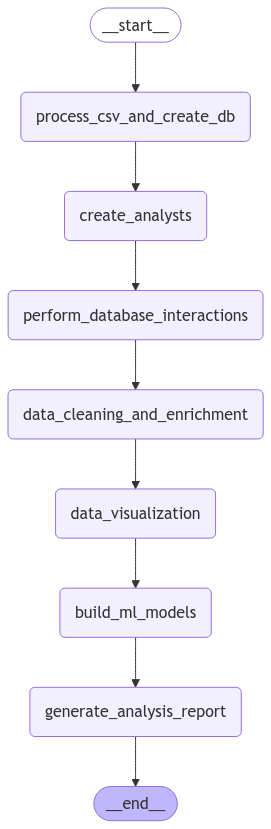

In [79]:
build_analysis_workflow()

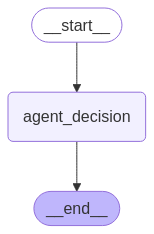

In [24]:
import json
from langgraph.graph import StateGraph, END, START
from langchain.tools import Tool
from langchain.chat_models import ChatOpenAI
from langchain.agents import initialize_agent
from langchain.agents import AgentType
from langchain.tools.sql_database.tool import QuerySQLDataBaseTool
from langchain.sql_database import SQLDatabase
from typing import Dict, Any



# Define tools
tools = [
    Tool(name="process_csv_and_create_db", func=process_csv_and_create_db, description="Processes CSV and creates a database."),
    Tool(name="create_analysts", func=create_analysts, description="Creates analysts."),
    Tool(name="perform_database_interactions", func=perform_database_interactions, description="Performs database interactions."),
    Tool(name="data_cleaning_and_enrichment", func=data_cleaning_and_enrichment, description="Cleans and enriches data."),
    Tool(name="data_visualization", func=data_visualization, description="Generates data visualizations."),
    Tool(name="build_ml_models", func=build_ml_models, description="Builds machine learning models."),
    Tool(name="generate_analysis_report", func=generate_analysis_report, description="Generates an analysis report."),
]

# Initialize Agent
agent = initialize_agent(tools=tools, llm=llm, agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION, verbose=True)

def agent_decision(state: Dict[str, Any]) -> Dict[str, Any]:
    """Agent decides which tool to call next."""
    query = "Based on the current state, which function should be called next?"
    response = agent.run(query)
    state["next_function"] = response
    return state

# Define Workflow
workflow = StateGraph(dict)
workflow.add_node("agent_decision", agent_decision)
workflow.add_edge(START, "agent_decision")
workflow.add_edge("agent_decision", END)

workflow.compile()

In [30]:
agent_decision = workflow.compile()

thread = {"configurable": {"thread_id": "1"}}

initial_state = {
    "csv_path": "train.csv",  
    "analysis_goal": "clean this data",
    "max_analysts": 4,
    "database_name": "agent",
    "table_name": "",
    "data_df": {} 
    }

agent_decision.invoke(initial_state, thread)



> Entering new AgentExecutor chain...


NotFoundError: <html>
<head><title>404 Not Found</title></head>
<body>
<center><h1>404 Not Found</h1></center>
<hr><center>nginx</center>
</body>
</html>

In [ ]:
def run_analysis(csv_file_path, analysis_goal, max_analysts=4, database_name=None, table_name=None):
    """Run the analysis workflow on a CSV file"""
    graph = build_analysis_workflow()

    # Initial state setup
    initial_state = {
    "csv_path": csv_file_path,  
    "analysis_goal": analysis_goal,
    "max_analysts": max_analysts,
    "database_name": database_name,
    "table_name": table_name,
    "data_df": {} 
    }

    thread = {"configurable": {"thread_id": "1"}}

    print("Initial state before running graph:", initial_state)

    # Run graph and stream results
    results = graph.invoke(initial_state, thread)

    print("Final results:", results)
    return results

In [81]:
run_analysis("train.csv", "analyse this data")

Initial state before running graph: {'csv_path': 'train.csv', 'analysis_goal': 'analyse this data', 'max_analysts': 4, 'database_name': None, 'table_name': None, 'data_df': {}}
⚠️ 'raw' key is present but not a DataFrame. Ensure correct format.
Starting generate_analysis_report
ml_models type: <class 'NoneType'>
Processing analyst with focus: Database Management
Processing analyst with focus: Data Preprocessing
Processing analyst with focus: Statistical Analysis
Processing analyst with focus: Machine Learning
Processing analyst with focus: Data Visualization
Successfully generated analysis report


{'csv_path': 'train.csv',
 'analysis_goal': 'analyse this data',
 'max_analysts': 4,
 'database_name': 'agent',
 'table_name': 'data_table',
 'analysts': [Analyst(name='Dexter Databuilder', affiliation='Data Operations Team', role='Database Engineer', data_analysis_focus='Database Management', description='Dexter is focused on creating and managing the database schema as defined in the analysis goal. He will ensure that the database is optimized for querying and retrieval of data. His approach includes setting up the schema, indexing critical columns, and ensuring data integrity.', analysis_results={'database_summary': {'database_created': 'agent', 'tables_created': ['data_table', 'None'], 'interactions_count': 0}}, database_interactions=[{'query': "\n            SELECT \n                COUNT(*) as row_count,\n                (SELECT COUNT(*) FROM information_schema.columns WHERE table_name = 'data_table') as column_count\n            FROM data_table\n            ", 'description': 'Ba

### Complex graph not working atm 

In [87]:
def human_feedback(state: GenerateAnalystsState):
    """Ask for human feedback and update state accordingly"""
    prompt = """
    Analyst Configuration Review
    ---------------------------
    
    The system has generated the following analysts:
    {}
    
    Would you like to:
    1. Continue with these analysts
    2. Modify the analysts and restart
    
    If modifying, please provide your suggestions:
    """.format(state.get('analysts', 'No analysts generated yet'))
    
    # Simulate user input (for testing purposes)
    user_choice = input(prompt)  # Replace this with actual user input mechanism
    user_suggestions = input("Provide your suggestions (if any): ") if user_choice == "2" else ""
    
    # Update the state with the feedback
    state["human_analyst_feedback"] = {
        "choice": user_choice,
        "suggestions": user_suggestions
    }
    
    return state

In [88]:
def should_continue_after_feedback(state: GenerateAnalystsState):
    """Determine next node after receiving human feedback"""
    # Check if feedback indicates we should restart
    human_analyst_feedback = state.get('human_analyst_feedback', {})
    choice = human_analyst_feedback.get('choice', '1')
    
    if choice == '2': 
        return "create_analysts"  # Restart the process
    
    return "perform_database_interactions"  # Continue to the next node

def should_loop_after_report(state: GenerateAnalystsState):
    """Determine if we should loop back for more feedback after the report"""
    report_feedback = state.get('report_feedback', {})
    needs_revision = report_feedback.get('needs_revision', False)
    
    if needs_revision:
        return "human_feedback"  # Loop back for feedback
    return END  # End the workflow

In [232]:
def should_loop_after_report(state: GenerateAnalystsState):
    """Determine if we should loop back for more feedback after the report"""
    report_feedback = state.get('report_feedback', {})
    needs_revision = report_feedback.get('needs_revision', False)
    
    if needs_revision:
        return "human_feedback"
    return END

# Build the workflow
def build_analysis_workflow():
    builder = StateGraph(GenerateAnalystsState)
    
    # Define nodes
    builder.add_node("process_csv_and_create_db", process_csv_and_create_db)
    builder.add_node("create_analysts", create_analysts)
    builder.add_node("human_feedback", human_feedback)
    builder.add_node("perform_database_interactions", perform_database_interactions)
    builder.add_node("data_cleaning_and_enrichment", data_cleaning_and_enrichment)
    builder.add_node("data_visualization", data_visualization)
    builder.add_node("build_ml_models", build_ml_models)
    builder.add_node("generate_analysis_report", generate_analysis_report)
    
    # Define workflow edges
    builder.add_edge(START, "process_csv_and_create_db")
    builder.add_edge("process_csv_and_create_db", "create_analysts")
    builder.add_edge("create_analysts", "human_feedback")
    
    # Add conditional edge after human_feedback to either continue or restart
    builder.add_conditional_edges(
        "human_feedback", 
        should_continue_after_feedback, 
        ["create_analysts", "perform_database_interactions"]
    )
    
    builder.add_edge("perform_database_interactions", "data_cleaning_and_enrichment")
    builder.add_edge("data_cleaning_and_enrichment", "data_visualization")
    builder.add_edge("data_visualization", "build_ml_models")
    builder.add_edge("build_ml_models", "generate_analysis_report")
    
    # Conditional loop for further human feedback after report generation
    builder.add_conditional_edges(
        "generate_analysis_report", 
        should_loop_after_report, 
        ["human_feedback", END]
    )
    
    # Compile the graph
    memory = MemorySaver()
    graph = builder.compile(
        interrupt_before=['human_feedback'], 
        checkpointer=memory
    )
    
    return graph

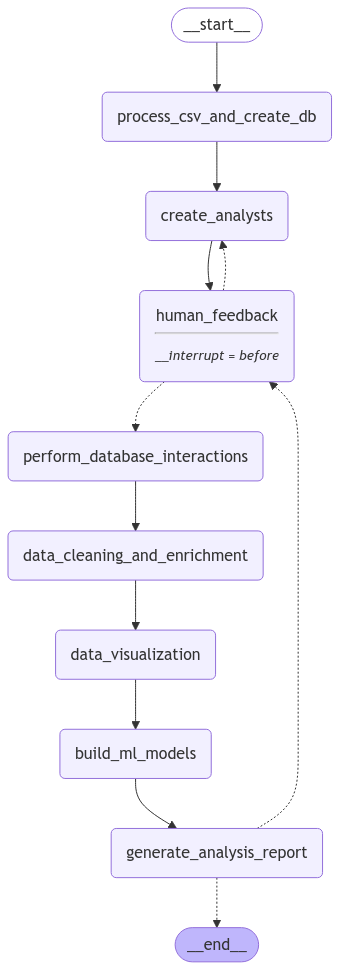

In [233]:
build_analysis_workflow()

In [92]:
def handle_human_feedback(state, config, interrupt_data):
    """Handle human feedback interruptions"""
    print("\n" + "="*50)
    print("HUMAN FEEDBACK REQUIRED")
    print("="*50)
    
    # Display the prompt
    prompt = state.get('feedback_prompt', 'Please provide feedback:')
    print(prompt)
    
    # Get user input
    choice = input("Your choice (1/2): ")
    suggestions = ""
    if choice == "2":
        suggestions = input("Please provide your suggestions: ")
    
    # Check if we're after report generation
    needs_revision = False
    revision_comments = ""
    if getattr(state, "report_generated", False):
        needs_revision = input("Does the report need revision? (y/n): ").lower() == 'y'
        if needs_revision:
            revision_comments = input("Revision comments: ")
    
    # Update the state
    state.human_analyst_feedback = {
        "choice": choice,
        "suggestions": suggestions
    }
    
    if getattr(state, "report_generated", False):
        state.report_feedback = {
            "needs_revision": needs_revision,
            "revision_comments": revision_comments
        }
    
    # Print separation line
    print("="*50)
    
    # Return the updated state
    return state

In [ ]:
run_analysis("train.csv", "")

In [420]:
run_analysis("train.csv", "plot a visualization")

Initial state before running graph: {'csv_path': 'train.csv', 'analysis_goal': 'plot a visualization', 'max_analysts': 4, 'database_name': None, 'table_name': None}
⚠️ Error parsing data_df: data_df is not a valid dictionary
⚠️ LLM response is not valid JSON. Returning raw response.
Final results: {'csv_path': 'train.csv', 'analysis_goal': 'plot a visualization', 'max_analysts': 4, 'database_name': 'agent', 'table_name': 'data_table', 'analysts': "Based on the analysis goals and dataset provided, here are four AI analyst personas assigned to distinct themes, each with their relevant expertise:\n\n### Theme 1: Data Aggregation and Preparation\n\n**Analyst: Data Engineer – Samira Techwood**\n\n**Expertise:** \n- Samira specializes in data ingestion, transformation, and loading (ETL processes). She has experience in working with large datasets and cleaning data to ensure consistent formats and quality.\n\n**Approach:** \n- Samira would first connect to the data source, ensuring that any e

{'csv_path': 'train.csv',
 'analysis_goal': 'plot a visualization',
 'max_analysts': 4,
 'database_name': 'agent',
 'table_name': 'data_table',
 'analysts': "Based on the analysis goals and dataset provided, here are four AI analyst personas assigned to distinct themes, each with their relevant expertise:\n\n### Theme 1: Data Aggregation and Preparation\n\n**Analyst: Data Engineer – Samira Techwood**\n\n**Expertise:** \n- Samira specializes in data ingestion, transformation, and loading (ETL processes). She has experience in working with large datasets and cleaning data to ensure consistent formats and quality.\n\n**Approach:** \n- Samira would first connect to the data source, ensuring that any extracted data maintains integrity. Given that there is no valid data found currently, she will set a framework for data validation. She’ll create pipelines to handle the transformation needed for the data schema, such as converting values to appropriate data types and filtering out irrelevant 